# exp002
evaluationを実装する

In [26]:
import os
import pandas as pd
import numpy as np
import ipynb_path
import simdkalman
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm

In [5]:
def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [7]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [8]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [9]:
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
ground_truth_train = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

In [11]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

In [12]:
def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [13]:
cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']

In [14]:
df_basepreds_kf = apply_kf_smoothing(base_train[cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [15]:
calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], 
               base_train['latDeg'], base_train['lngDeg']).mean()

3.8468483749908207

In [16]:
calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], 
               df_basepreds_kf['latDeg'], df_basepreds_kf['lngDeg']).mean()

3.390778191300677

In [17]:
base_train['err'] = calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], base_train['latDeg'], base_train['lngDeg'])

In [18]:
df_basepreds_kf['err'] = calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], df_basepreds_kf['latDeg'], df_basepreds_kf['lngDeg'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
base_train

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,err
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.213483
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,1.650722
...,...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,2.052491
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,2.671673
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,2.287458
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,3.454306


In [20]:
df_basepreds_kf

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,err
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423549,-122.094006,11.478435
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423564,-122.094063,6.235337
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094098,3.064335
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423578,-122.094116,1.426618
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094123,0.866614
...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334466,-121.899597,1.764769
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334473,-121.899592,1.915169
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334481,-121.899588,2.314484
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334487,-121.899582,3.126604


In [21]:
base_train_result = base_train.groupby('phone')['err'].agg([percentile50, percentile95])

base_train_result['p50_p90_mean'] = (base_train_result['percentile50'] + base_train_result['percentile95']) / 2 

base_train_score = base_train_result['p50_p90_mean'].mean()
base_train_score

5.287970649084159

In [22]:
df_basepreds_kf['phone'] = df_basepreds_kf['collectionName'] + '_' + df_basepreds_kf['phoneName']
df_basepreds_kf_result = df_basepreds_kf.groupby('phone')['err'].agg([percentile50, percentile95])

df_basepreds_kf_result['p50_p90_mean'] = (df_basepreds_kf_result['percentile50'] + df_basepreds_kf_result['percentile95']) / 2 

df_basepreds_kf_score = df_basepreds_kf_result['p50_p90_mean'].mean()
df_basepreds_kf_score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4.603545406489522

In [29]:
tmp = base_train_result.reset_index()

In [24]:
base_train_result.sort_values('p50_p90_mean')

,percentile50,percentile95,p50_p90_mean
phone,,,
2020-06-11-US-MTV-1_Pixel4XL,1.017757,2.706992,1.862374
2020-06-05-US-MTV-1_Pixel4XL,1.087586,2.659052,1.873319
2020-06-04-US-MTV-1_Pixel4XL,1.158603,2.800130,1.979366
2020-07-08-US-MTV-1_Pixel4XL,1.271282,2.783548,2.027415
2020-08-06-US-MTV-2_Pixel4XL,1.133817,3.032466,2.083141
...,...,...,...
2021-04-22-US-SJC-1_SamsungS20Ultra,7.405150,28.131201,17.768176
2021-04-29-US-SJC-2_SamsungS20Ultra,5.944472,32.945158,19.444815
2021-04-28-US-SJC-1_SamsungS20Ultra,5.727631,34.614164,20.170898


In [43]:
tmp['phoneName'] = tmp['phone'].str.split('_',expand=True)[1]

<AxesSubplot:xlabel='phoneName', ylabel='p50_p90_mean'>

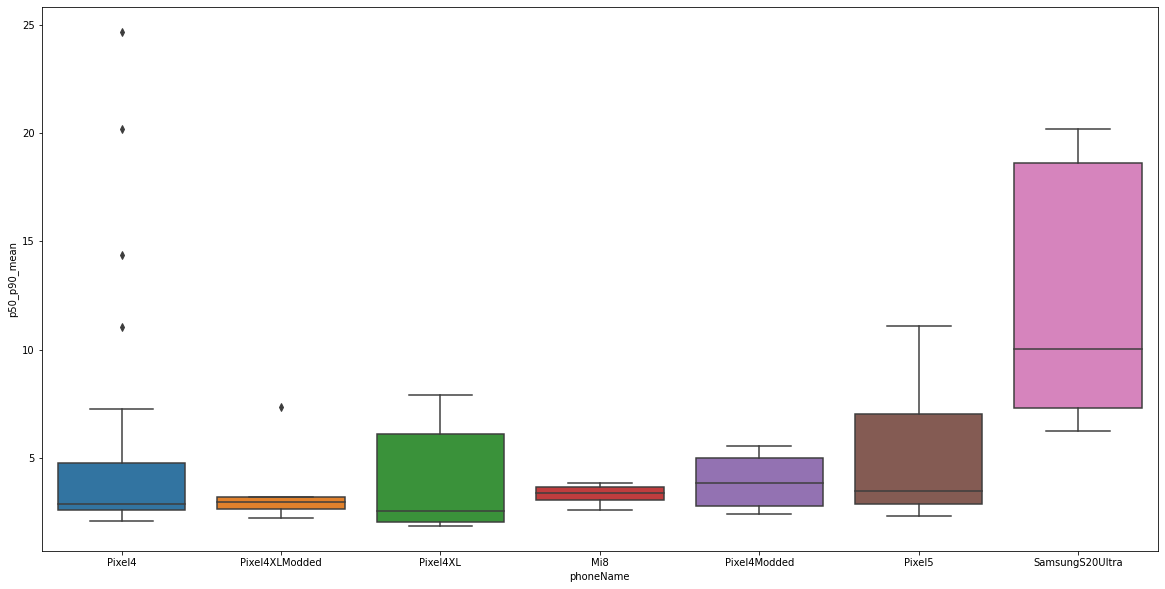

In [45]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="phoneName", y="p50_p90_mean", data=tmp)